In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Reddit Title Formality Classification
In this notebook, we walk through three different models for our data: logistic regression, ordinal regression, and BERT classifier. We saw that the BERT classifier had the highest test accuracy of 40%. After we used the various models, we analyzed the BOW features from the logistic regression model and the confusion matrix from the BERT classifier.

In [ ]:
# paths to our data files

from google.colab import drive
drive.mount('/content/drive')

train_path = "/content/drive/My Drive/content/train.txt"
dev_path = "/content/drive/My Drive/content/dev.txt"
test_path = "/content/drive/My Drive/content/test.txt"

Mounted at /content/drive


In [ ]:
# useful functions

def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

# Logistic Regression

In [ ]:
def load_data(filename):
    X = []
    Y = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            Y.append(label)

    return X, Y

In [ ]:
class Classifier:

    def __init__(self, feature_method, trainX, trainY, devX, devY, testX, testY):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_reg = None

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    # Train model and evaluate on held-out data
    def train(self):
        (D,F) = self.trainX.shape
        best_dev_accuracy=0
        best_model=None
        for C in [0.1, 1, 10, 100]:
            self.log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
            self.log_reg.fit(self.trainX, self.trainY)
            training_accuracy = self.log_reg.score(self.trainX, self.trainY)
            development_accuracy = self.log_reg.score(self.devX, self.devY)
            if development_accuracy > best_dev_accuracy:
                best_dev_accuracy=development_accuracy
                best_model=self.log_reg

#             print("C: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (C, training_accuracy, development_accuracy))

        self.log_reg=best_model
        

    def test(self):
        return self.log_reg.score(self.testX, self.testY)
        

    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

            

In [ ]:
def run_logistic(trainingFile, devFile, testFile):
    trainX, trainY=load_data(trainingFile)
    devX, devY=load_data(devFile)
    testX, testY=load_data(testFile)
    
    simple_classifier = Classifier(binary_bow_featurize, trainX, trainY, devX, devY, testX, testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()
    
    lower, upper=confidence_intervals(accuracy, len(testY), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

    simple_classifier.printWeights()

In [ ]:
trainingFile = train_path
devFile = dev_path
testFile = test_path
    
run_logistic(trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.255, 95% CIs: [0.195 0.315]

1	0.179	fucking
1	0.168	fuck
1	0.159	is
1	0.153	week
1	0.093	f
1	0.093	ship
1	0.092	posted
1	0.092	cry
1	0.092	<
1	0.091	banned

2	0.260	fuck
2	0.230	nut
2	0.220	then
2	0.220	can
2	0.217	an
2	0.194	missing
2	0.192	?
2	0.185	help
2	0.183	else
2	0.180	are

3	0.359	be
3	0.355	my
3	0.254	:
3	0.253	finals
3	0.224	like
3	0.223	the
3	0.211	ama
3	0.200	post
3	0.197	fun
3	0.183	some

4	0.316	a
4	0.256	to
4	0.249	girl
4	0.244	good
4	0.231	students
4	0.230	made
4	0.208	know
4	0.200	every
4	0.199	all
4	0.167	what

5	0.770	!
5	0.501	from
5	0.483	i
5	0.250	berkeley
5	0.242	view
5	0.222	in
5	0.220	your
5	0.216	``
5	0.213	&
5	0.205	cal

6	0.523	.
6	0.310	do
6	0.306	time
6	0.296	,
6	0.288	their
6	0.248	to
6	0.233	2019
6	0.215	on
6	0.211	cal
6	0.196	top

7	0.439	.
7	0.398	uc
7	0.350	at
7	0.329	berkeley
7	0.308	's
7	0.262	park
7	0.257	of
7	0.244	new
7	0.243	california
7	0.215	will



# Ordinal Regression


In [ ]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y

In [ ]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        data = self.featurize(X_data)
        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X

    def train(self):
        (D,F) = self.trainX.shape

        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:
                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg

            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
            
        for data_point in range(len(preds[0])):
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot

In [ ]:
def run_ordinal(trainingFile, devFile, testFile, ordinal_values):
    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy=simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

In [ ]:
trainingFile = train_path
devFile = dev_path
testFile = test_path
    
# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]

ordinal_values=["1", "2", "3", "4", "5", "6", "7"]

run_ordinal(trainingFile, devFile, testFile, ordinal_values)

Test accuracy for best dev model: 0.290, 95% CIs: [0.227 0.353]



### BERT Classifier

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 77 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 6.6 MB 25.6 MB/s 
     |████████████████████████████████| 895 kB 33.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertModel, BertTokenizer
import nltk
import torch
import torch.nn as nn
import numpy as np
import random
from scipy.stats import norm
import math

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
def read_labels(filename):
    labels={}
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            if label not in labels:
                labels[label]=len(labels)
    return labels

In [ ]:
def read_data(filename, labels, max_data_points=1000):
  
    data = []
    data_labels = []
    with open(filename) as file:
        for line in file:
            cols = line.split("\t")
            label = cols[1]
            text = cols[2]
            
            data.append(text)
            data_labels.append(labels[label])
            

    # shuffle the data
    tmp = list(zip(data, data_labels))
    random.shuffle(tmp)
    data, data_labels = zip(*tmp)
    
    if max_data_points is None:
        return data, data_labels
    
    return data[:max_data_points], data_labels[:max_data_points]

In [ ]:
labels= read_labels(train_path)
train_x, train_y=read_data(train_path, labels, max_data_points=None)
dev_x, dev_y=read_data(dev_path, labels, max_data_points=None)
test_x, test_y=read_data(test_path, labels, max_data_points=None)

In [ ]:
# needed to retrieve the true labels
reverse_labels = {val:key for key, val in labels.items()}
reverse_labels

{0: '2', 1: '6', 2: '3', 3: '4', 4: '5', 5: '1', 6: '7'}

In [ ]:
# we see that the read labels function changes our true label, we must use our reverse_labels dictionary to return the true label
list(zip(test_x, test_y))[0], list(zip(test_x, [reverse_labels[val] for val in test_y]))[0]

(('CalDining needs to change.\n', 1), ('CalDining needs to change.\n', '6'))

In [ ]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    predictions = [] # new code
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                predictions.append(prediction.item())
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total, total, predictions

In [ ]:
class BERTClassifier(nn.Module):

    def __init__(self, bert_model_name, params):
        super().__init__()
    
        self.model_name=bert_model_name
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        self.bert = BertModel.from_pretrained(self.model_name)
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=510):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

      # We're going to represent an entire document just by its [CLS] embedding (at position 0)
      # And use the *last* layer output (layer -1)
      # as a result of this choice, this embedding will be optimized for this purpose during the training process.
      
        bert_hidden_states = bert_output['hidden_states']

        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [ ]:
def train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

    bert_model = BERTClassifier(bert_model_name, params={"label_length": len(labels), "doLowerCase":doLowerCase, "embedding_size":embedding_size})
    bert_model.to(device)

    batch_x, batch_y = bert_model.get_batches(train_x, train_y)
    dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

    optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
    cross_entropy=nn.CrossEntropyLoss()

    num_epochs=30
    best_dev_acc = 0.
    patience=5

    best_epoch=0

    for epoch in range(num_epochs):
        bert_model.train()

        # Train
        for x, y in zip(batch_x, batch_y):
            y_pred = bert_model.forward(x)
            loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate
        dev_accuracy, _, _=evaluate(bert_model, dev_batch_x, dev_batch_y)
        if epoch % 1 == 0:
            print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
            if dev_accuracy > best_dev_acc:
                torch.save(bert_model.state_dict(), model_filename)
                best_dev_acc = dev_accuracy
                best_epoch=epoch
        if epoch - best_epoch > patience:
            print("No improvement in dev accuracy over %s epochs; stopping training" % patience)
            break

    bert_model.load_state_dict(torch.load(model_filename))
    print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
    return bert_model

In [ ]:
# small BERT -- can run on laptop
# bert_model_name="google/bert_uncased_L-2_H-128_A-2"
# model_filename="mybert.model"
# embedding_size=128
# doLowerCase=True

# bert-base -- slow on laptop; better on Colab
bert_model_name="bert-base-cased"
model_filename="mybert.model"
embedding_size=768
doLowerCase=False

model=train(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=embedding_size, doLowerCase=doLowerCase)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 0, dev accuracy: 0.240
Epoch 1, dev accuracy: 0.260
Epoch 2, dev accuracy: 0.250
Epoch 3, dev accuracy: 0.270
Epoch 4, dev accuracy: 0.280
Epoch 5, dev accuracy: 0.305
Epoch 6, dev accuracy: 0.310
Epoch 7, dev accuracy: 0.305
Epoch 8, dev accuracy: 0.310
Epoch 9, dev accuracy: 0.300
Epoch 10, dev accuracy: 0.325
Epoch 11, dev accuracy: 0.330
Epoch 12, dev accuracy: 0.315
Epoch 13, dev accuracy: 0.310
Epoch 14, dev accuracy: 0.310
Epoch 15, dev accuracy: 0.305
Epoch 16, dev accuracy: 0.320
Epoch 17, dev accuracy: 0.310
No improvement in dev accuracy over 5 epochs; stopping training

Best Performing Model achieves dev accuracy of : 0.330


In [ ]:
test_batch_x, test_batch_y = model.get_batches(test_x, test_y)
accuracy, test_n, predictions=evaluate(model, test_batch_x, test_batch_y)

lower, upper=confidence_intervals(accuracy, test_n, .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

Test accuracy for best dev model: 0.375, 95% CIs: [0.308 0.442]



# Analysis
From the above logistic regression, we again consider the highest weights for each bag-of-word feature for each class.



In [ ]:
# here we reproduce the data
run_logistic(trainingFile, devFile, testFile)

Test accuracy for best dev model: 0.255, 95% CIs: [0.195 0.315]

1	0.179	fucking
1	0.168	fuck
1	0.159	is
1	0.153	week
1	0.093	f
1	0.093	ship
1	0.092	posted
1	0.092	cry
1	0.092	<
1	0.091	banned

2	0.260	fuck
2	0.230	nut
2	0.220	then
2	0.220	can
2	0.217	an
2	0.194	missing
2	0.192	?
2	0.185	help
2	0.183	else
2	0.180	are

3	0.359	be
3	0.355	my
3	0.254	:
3	0.253	finals
3	0.224	like
3	0.223	the
3	0.211	ama
3	0.200	post
3	0.197	fun
3	0.183	some

4	0.316	a
4	0.256	to
4	0.249	girl
4	0.244	good
4	0.231	students
4	0.230	made
4	0.208	know
4	0.200	every
4	0.199	all
4	0.167	what

5	0.770	!
5	0.501	from
5	0.483	i
5	0.250	berkeley
5	0.242	view
5	0.222	in
5	0.220	your
5	0.216	``
5	0.213	&
5	0.205	cal

6	0.523	.
6	0.310	do
6	0.306	time
6	0.296	,
6	0.288	their
6	0.248	to
6	0.233	2019
6	0.215	on
6	0.211	cal
6	0.196	top

7	0.439	.
7	0.398	uc
7	0.350	at
7	0.329	berkeley
7	0.308	's
7	0.262	park
7	0.257	of
7	0.244	new
7	0.243	california
7	0.215	will



Here we can see our most prominent BOW features for each label. It is expected that punctuation like "." would have a high weight for the more formal classes, and it is interesting to see that the exclamation mark "!" was the most weighted feature for the label "5" (this can be explained by the fact that many titles that were gramatically correct and formal but included exclamation marks were downgraded from "6"/"7" to "5".)

It is also no surprise that for the less formal labels like "1" and "2" that swear words and slang are the most promiennt features. 

We also see that for the less polarized classes that the prominent features are more common and neutral words such as "a", "to", "berkeley", etc.

### Clean Data
Because of the nature of the `read_labels` function, the labels we see in our predictions are not our true labels. Return the labels using our `reverse_labels` dictionary.

In [ ]:
# we see that the labels are 0 indexed for BERT
set(predictions), set(test_y)

({0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6})

In [ ]:
predictions_fixed = [int(reverse_labels[val]) for val in predictions]
test_y_fixed = [int(reverse_labels[val]) for val in test_y]

In [ ]:
set(predictions_fixed), set(test_y_fixed) # returned to our label scheme

({1, 2, 3, 4, 5, 6, 7}, {1, 2, 3, 4, 5, 6, 7})

### Confusion Matrix
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(test_y_fixed, predictions_fixed, labels=[1, 2, 3, 4, 5, 6, 7])

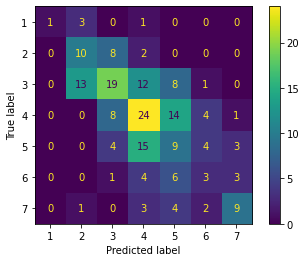

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6, 7])
disp.plot()
plt.show()

We see that our confusion matrix has expected and proper behavior in that—for the most part—the predicted labels are only one label away from the true label. 

We also see that the test data is roughly normal as there are more samples for labels like 3,4,5 and less samples for labels like 1,7. This suggests that our data was not very uniform/balanced, and we could have benefitted from introducing larger weights for the less represented classes.

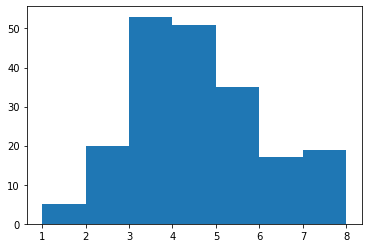

In [ ]:
# most of the labels are 3, 4, 5
plt.hist(test_y_fixed, [1, 2, 3, 4, 5, 6, 7, 8], align="mid");

## Class Comparisons
For each prediction label, let's see what the true labels were to see how close our BERT classifier was in the end.

In [ ]:
def show_true_labels(target_class):
  pred = [index for index, val in enumerate(predictions_fixed) if val == target_class]
  pred_x = [val for index, val in enumerate(test_x) if index in pred]
  pred_true = [val for index, val in enumerate(test_y_fixed) if index in pred]

  for data, label in zip(pred_x, pred_true):
    print(f"Title: {data}", f"True label: {label}", f"Predicted label: {target_class}")


show_true_labels(7)

Title: UC Berkeley may be forced by court to cut 3,000 freshman seats to halt growth
 True label: 7 Predicted label: 7
Title: Black at Berkeley
 True label: 5 Predicted label: 7
Title: Nick Weaver on UCOP's Data Breach Notifications
 True label: 7 Predicted label: 7
Title: Why I Think Fall will be On-Line Only (Nick Weaver)
 True label: 6 Predicted label: 7
Title: Morning from the roof of Evans Hall
 True label: 5 Predicted label: 7
Title: Dr. Fauci will speak at the Berkeley Forum on August 27th!
 True label: 6 Predicted label: 7
Title: Over 20 Women Come Forward to Accuse UC Berkeley Student of Sexual Assault
 True label: 7 Predicted label: 7
Title: The Berkeley campus captured by Ansel Adams (1966)
 True label: 6 Predicted label: 7
Title: 1:100 Scale Working Campanile!
 True label: 4 Predicted label: 7
Title: Would you support the recall of ASUC senator Gabbi Sharp?
 True label: 7 Predicted label: 7
Title: CSU East Bay, Satellite Campus
 True label: 7 Predicted label: 7
Title: Today

In [ ]:
show_true_labels(2)

Title: STOP THE COUNT!
 True label: 3 Predicted label: 2
Title: Hmm
 True label: 2 Predicted label: 2
Title: saw this on sproul today :)
 True label: 3 Predicted label: 2
Title: Spotted a handsome boi outside Sproul (IG: @uc.barkeley)
 True label: 2 Predicted label: 2
Title: just committed!!!! so excited to be a baby bear 🐻💛💙
 True label: 2 Predicted label: 2
Title: I fucking love Berkeley lmao
 True label: 1 Predicted label: 2
Title: Anybody else lowkey wish this semester was PNP?
 True label: 3 Predicted label: 2
Title: y’all ready for this?
 True label: 3 Predicted label: 2
Title: Fuck
 True label: 1 Predicted label: 2
Title: a gal in EECS here to vent about men
 True label: 3 Predicted label: 2
Title: BEARS IN PENNSYLVANIA — MISSING CAL STUDENT
 True label: 3 Predicted label: 2
Title: Jack-O(ski)-Lantern 🎃
 True label: 2 Predicted label: 2
Title: UPDATE: Got my frisbee back s/o Dean Jacobsen
 True label: 3 Predicted label: 2
Title: Respectfully, fuck EECS 16B
 True label: 2 Predict

For both predicted labels 7 and 2, we see that our predictions were often quite close, and for whenever our model predicted 2, the true labels were always in the range 1 to 3, suggesting that the model was on the right track but suffered from the more precise labeling.

We can also see what our predictions were for each true class.

In [ ]:
def show_pred_labels(true_class):
  tru = [index for index, val in enumerate(test_y_fixed) if val == true_class]
  pred_x = [val for index, val in enumerate(test_x) if index in tru]
  pred_y = [val for index, val in enumerate(predictions_fixed) if index in tru]

  for data, label in zip(pred_x, pred_y):
    print(f"Title: {data}", f"True label: {true_class}", f"Predicted label: {label}")

show_pred_labels(7)


Title: UC Berkeley may be forced by court to cut 3,000 freshman seats to halt growth
 True label: 7 Predicted label: 7
Title: Nick Weaver on UCOP's Data Breach Notifications
 True label: 7 Predicted label: 7
Title: UC Davis Student Government Passes New Resolution
 True label: 7 Predicted label: 6
Title: UC Berkeley must withhold thousands of acceptance letters after state Supreme Court ruling
 True label: 7 Predicted label: 6
Title: Over 20 Women Come Forward to Accuse UC Berkeley Student of Sexual Assault
 True label: 7 Predicted label: 7
Title: UC Ranking by Major
 True label: 7 Predicted label: 4
Title: I made a list of the 21 things you need to do and experience in Berkeley before you graduate, as well as my bucket list for the surrounding area--also good if you're looking for ways to spend spring break! Have I left anything out?
 True label: 7 Predicted label: 5
Title: VIDEO: Man fired after blocking UC Berkeley graduate Michael Barajas from entering his own apartment building
 T

We see that for our outlier prediction of 3, our model was heavily influenced by the presence of quotations ("").

In general, our model suffered in a similar way as we—the annotators—did in that we realized that Reddit post titles are very varied and can come in many different formats. One thing that may have fixed our problem was to use data that was in the same format (i.e. all sentences or all headlines) because it was difficult to compare the formality of a proper headline (e.g. "EECS Funding Crisis: What You Can Do Right Now") vs formality of a full-on proper sentence (e.g. "Staff at the Berkeley Lab sit atop the center of the cyclotron in 1938.") We ended up treating proper headlines as 7s, but this was a confusing nuance that our model could not overcome and one that we would ultimately reevaluate (among other details) in our annotation guidelines if we were to redo this project. 

## Evaluating Evaluation

Now let's see if we are a little more lenient in our evaluation how much our accuracy improves. We will first start by considering the label to the left and right as correct, this cuts down our range.

In [ ]:
def eval_lenient(pred_labels, true_labels):
  total = 0
  correct = 0

  for pred, tru in zip(pred_labels, true_labels):
    if pred in {tru-1, tru, tru+1}:
      correct += 1
    total += 1

  return correct / total

In [ ]:
eval_lenient(predictions_fixed, test_y_fixed)

0.815

This higher test accuracy with our more lenient evaluation suggests that if we posed a simpler question then we could have had higher model performance (though it would not necessarily be of more use as the results would be less precise).

Similarly, we could turn our current ordinal classification into binary classification by changing the scale to be even (e.g. 1-8) and then have the labels 1-4 be the "informal" label and labels 5-8 to be the "formal" label.